In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from backend.data_processing_service import DataProcessingService
from backend.model_service import ModelService, LinRegNN

# Initialize DataProcessingService
data_processor = DataProcessingService(seq_length=10, pred_window=1, batch_size=10)
data = np.loadtxt('data/normalized_apple_prices.csv')
# data = data_processor.get_sample_data(length=50)

# Normalize the data
data_normalized, scaler = data_processor.normalize_data(data)

# Create sequences
x_data, y_data = data_processor.create_sequences(data_normalized)

# Split data into training and test sets
x_train, x_test, y_train, y_test = data_processor.split_data(x_data, y_data, train_ratio=0.8)

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

ms = ModelService()


In [3]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

torch.Size([102, 10, 1]) torch.Size([102, 1, 1]) torch.Size([26, 10, 1]) torch.Size([26, 1, 1])


In [3]:
# Define the search space for hyperparameters
model_params_space = {
    'input_size': data_processor.seq_length,
    'output_size': data_processor.pred_window
}

# Run hyperparameter optimization
best_hyperparams = ModelService.hyperparameter_optimization(LinRegNN, x_train, y_train, x_test, y_test, model_params_space, max_evals=5)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

Epoch [1/13], Loss: 0.2736                           
Epoch [2/13], Loss: 0.2413                           
Epoch [3/13], Loss: 0.4813                           
Epoch [4/13], Loss: 0.5030                           
Epoch [5/13], Loss: 1.2694                           
Checkpoint saved at backend/checkpoints/test_5.pth   
Epoch [6/13], Loss: 1.3971                           
Epoch [7/13], Loss: 2.0040                           
Epoch [8/13], Loss: 1.4015                           
Epoch [9/13], Loss: 1.4608                           
Epoch [10/13], Loss: 0.8221                          
Checkpoint saved at backend/checkpoints/test_10.pth  
Epoch [11/13], Loss: 0.8945                          
Epoch [12/13], Loss: 0.4971                          
Epoch [13/13], Loss: 0.6684                          
Test Loss: 0.1256                                    
Epoch [1/18], Loss: 0.4427                                                      
Epoch [2/18], Loss: 0.2173                             

In [4]:
# Extract best hyperparameters
# best_hidden_size = best_hyperparams['model_params']['hidden_size']
best_learning_rate = best_hyperparams['learning_rate']
best_epochs = int(best_hyperparams['epochs'])
best_hyperparams

{'epochs': 20.0, 'learning_rate': 0.029838439085646224}

In [5]:
# Initialize the model with best hyperparameters
model = LinRegNN(data_processor.seq_length, data_processor.pred_window)

In [6]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

# Training loop
ms = ModelService.wandb_login()
# ms.wandb_login()
model.train_loop(model, criterion, optimizer, x_train, y_train, epochs=best_epochs, directory = "backend/checkpoints/lr01_", wandb_project="times_fw")
# Eval
model.evaluation(model, x_test, y_test, criterion)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emilio-piotto. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Usuario\.netrc


Epoch [1/20], Loss: 0.2422
Epoch [2/20], Loss: 0.0437
Epoch [3/20], Loss: 0.1038
Epoch [4/20], Loss: 0.0388
Epoch [5/20], Loss: 0.1163
Checkpoint saved at backend/checkpoints/lr01_5.pth
Epoch [6/20], Loss: 0.0521
Epoch [7/20], Loss: 0.1554
Epoch [8/20], Loss: 0.0793
Epoch [9/20], Loss: 0.2132
Epoch [10/20], Loss: 0.1067
Checkpoint saved at backend/checkpoints/lr01_10.pth
Epoch [11/20], Loss: 0.2436
Epoch [12/20], Loss: 0.1077
Epoch [13/20], Loss: 0.2227
Epoch [14/20], Loss: 0.0875
Epoch [15/20], Loss: 0.1847
Checkpoint saved at backend/checkpoints/lr01_15.pth
Epoch [16/20], Loss: 0.0684
Epoch [17/20], Loss: 0.1578
Epoch [18/20], Loss: 0.0585
Epoch [19/20], Loss: 0.1463
Epoch [20/20], Loss: 0.0566
Checkpoint saved at backend/checkpoints/lr01_20.pth


average_loss,█▁▃▁▄▁▅▂▇▃█▃▇▃▆▂▅▂▅▂
average_loss,0.05656


Test Loss: 0.0196


0.01961362314831114

In [7]:
model.register(model, name="template_test")

Model saved successfully.


In [2]:
from backend.model_service import ModelService
model_service = ModelService()
model = model_service.load_registered_model("backend/models/template_test")

Model loaded successfully.


In [4]:
x_new = torch.tensor(x_test[:5], dtype=torch.float32)  # Example of new input data
predicted_mean, lower_bound, upper_bound = model.predict_with_confidence_intervals(model, x_new, num_samples=100, alpha=0.05)

# Print results
print("Predicted Mean:", predicted_mean)
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Predicted Mean: tensor([-0.0060, -0.1197, -0.0890, -0.1134,  0.0051])
Lower Bound: tensor([-0.0198, -0.1354, -0.1016, -0.1269, -0.0093])
Upper Bound: tensor([ 0.0078, -0.1040, -0.0765, -0.1000,  0.0195])


C:\Users\Usuario\AppData\Local\Temp\ipykernel_9560\3677665127.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new = torch.tensor(x_test[:5], dtype=torch.float32)  # Example of new input data


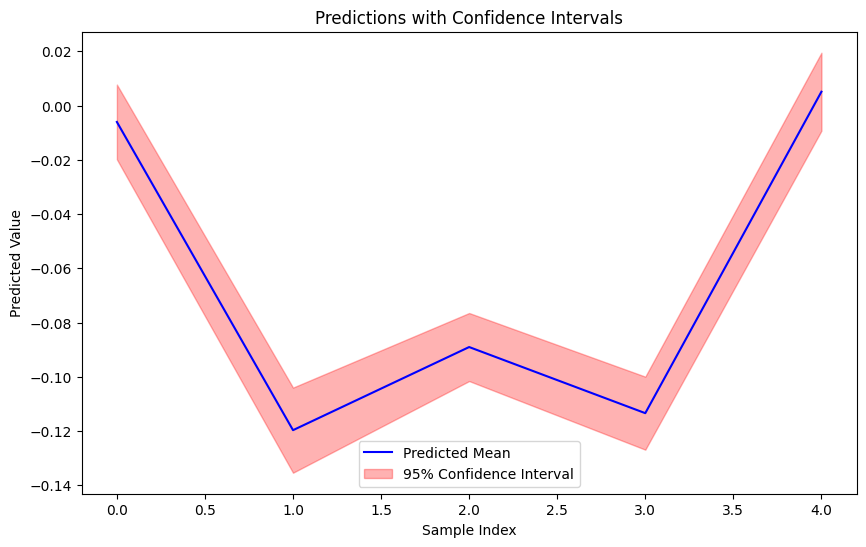

In [5]:
import matplotlib.pyplot as plt
x_indices = np.arange(len(x_new))
plt.figure(figsize=(10, 6))
plt.plot(x_indices, predicted_mean.numpy(), label='Predicted Mean', color='b')
plt.fill_between(x_indices, lower_bound.numpy(), upper_bound.numpy(), color='r', alpha=0.3, label='95% Confidence Interval')
plt.title('Predictions with Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()